# Solving the n-Queens Problem using Local Search

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]


## Learning Outcomes

* Implement multiple hill climbing search variants to solve the n-Queens problem.
* Apply simulated annealing with appropriate temperature scheduling to overcome local optima.
* Compare algorithm performance using runtime, solution quality, and success rate metrics.
* Analyze and visualize algorithm performance across different problem sizes.
* Graduate Students: Design and test alternative local move operators to improve search efficiency.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file. 

## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum. 

## Helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""
    
    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Calculate the number of conflicts, i.e., the objective function."""

    n = len(board)
    
    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n
    
    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1
    
    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

# decrease the font size to fit larger boards
def show_board(board, cols = ['white', 'gray'], fontsize = 48):  
    """display the board"""
    
    n = len(board)
    
    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0): 
                display[i,j] = 1
    
    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap, 
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])
    
    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize, 
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 4 conflicts.


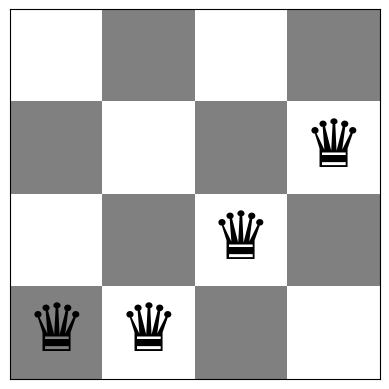

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [2]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


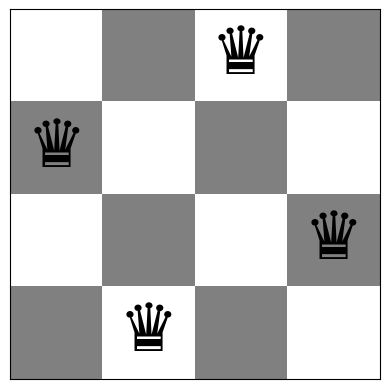

In [3]:
board = [1,3,0,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [20 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum. 

In [5]:
def steepest_ascent_hill_climbing(n, max_iters=1000):
    board = random_board(n)
    current_conflicts = conflicts(board)
    steps = [current_conflicts]  # để lưu lại quá trình hội tụ

    for _ in range(max_iters):
        best_board = board.copy()
        best_conflicts = current_conflicts

        # thử di chuyển từng hậu sang các hàng khác
        for col in range(n):
            for row in range(n):
                if board[col] == row:
                    continue
                new_board = board.copy()
                new_board[col] = row
                new_conflicts = conflicts(new_board)
                if new_conflicts < best_conflicts:
                    best_board = new_board
                    best_conflicts = new_conflicts

        # nếu không có cải thiện, dừng lại
        if best_conflicts >= current_conflicts:
            break

        # cập nhật board tốt nhất
        board = best_board
        current_conflicts = best_conflicts
        steps.append(current_conflicts)

        # nếu đạt nghiệm (0 conflict) thì thoát
        if current_conflicts == 0:
            break

    return board, current_conflicts

## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

In [6]:
import random

def stochastic_hill_climbing_1(n, max_iters=1000):
    board = random_board(n)
    current_conflicts = conflicts(board)
    steps = [current_conflicts]

    for _ in range(max_iters):
        improving_neighbors = []

        for col in range(n):
            for row in range(n):
                if board[col] == row:
                    continue
                new_board = board.copy()
                new_board[col] = row
                new_conflicts = conflicts(new_board)
                if new_conflicts < current_conflicts:
                    improving_neighbors.append((new_board, new_conflicts))

        if not improving_neighbors:
            break

        board, current_conflicts = random.choice(improving_neighbors)
        steps.append(current_conflicts)

        if current_conflicts == 0:
            break

    return board, current_conflicts


## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__ 

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

In [7]:
def stochastic_hill_climbing_2(n, max_iters=10000, no_improve_limit=1000):
    board = random_board(n)
    current_conflicts = conflicts(board)
    steps = [current_conflicts]

    no_improve_count = 0

    for _ in range(max_iters):
        # Sinh 1 neighbor ngẫu nhiên
        new_board = board.copy()
        col = random.randint(0, n - 1)
        new_row = random.randint(0, n - 1)
        while new_row == new_board[col]:
            new_row = random.randint(0, n - 1)
        new_board[col] = new_row

        new_conflicts = conflicts(new_board)

        # Nếu neighbor tốt hơn → chấp nhận
        if new_conflicts < current_conflicts:
            board = new_board
            current_conflicts = new_conflicts
            steps.append(current_conflicts)
            no_improve_count = 0
        else:
            no_improve_count += 1

        # Dừng nếu không cải thiện sau nhiều lần thử
        if no_improve_count > no_improve_limit or current_conflicts == 0:
            break

    return board, current_conflicts

## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algorithm several times starting with a new random board.

Found solution at restart 0, step 5
Board with 0 conflicts.


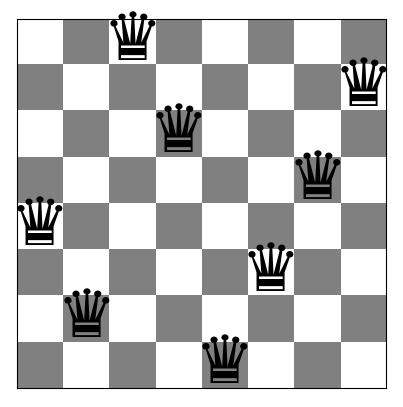

elapsed_time:0.05067729949951172[sec]
Found solution at restart 0, step 2
Board with 0 conflicts.


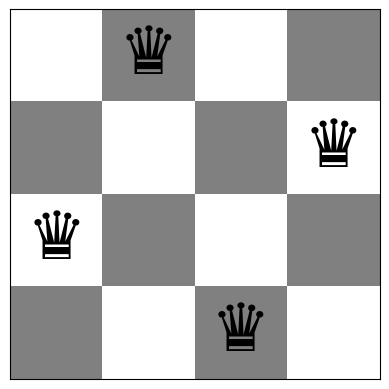

elapsed_time:0.04837155342102051[sec]


In [7]:
# Code and description go here
# Tú generate function
import time
def get_neighbours(board):
    """Sinh tất cả láng giềng bằng cách di chuyển 1 quân hậu trong cột khác hàng"""
    n = len(board)
    neighbors = []
    for col in range(n):
        for row in range(n):
            if board[col] != row:  # chỉ thay đổi nếu khác hàng
                new_board = board.copy()
                new_board[col] = row
                neighbors.append(new_board)
    return neighbors

def random_restart_hill_climbing(n, max_restarts=100, max_steps=1000, show=False):
    best_board = None
    best_conf = float("inf")

    for restart in range(max_restarts):
        board = random_board(n)
        current_board = board.copy()
        current_conf = conflicts(current_board)

        for step in range(max_steps):
            if current_conf == 0:
                print(f"Found solution at restart {restart}, step {step}")
                if show: show_board(current_board)
                return current_board

            neighbors = get_neighbours(current_board)
            neighbor_conflicts = [conflicts(nb) for nb in neighbors]

            min_conf = min(neighbor_conflicts)
            if min_conf >= current_conf:
                break  # mắc kẹt → restart mới

            best_neighbor = neighbors[neighbor_conflicts.index(min_conf)]
            current_board = best_neighbor
            current_conf = min_conf

        # lưu nghiệm tốt nhất trong trường hợp không tìm được nghiệm hoàn hảo
        if current_conf < best_conf:
            best_conf = current_conf
            best_board = current_board

    print(f"No perfect solution found after {max_restarts} restarts. Best conflicts = {best_conf}")
    if show and best_board is not None:
        show_board(best_board)
    return best_board
start1 = time.time()
solution = random_restart_hill_climbing(8, max_restarts=100, show=True)
end1 = time.time()
elapsed_time1 = end1 - start1
print ("elapsed_time:{0}".format(elapsed_time1) + "[sec]")
start2 = time.time()
solution2 = random_restart_hill_climbing(4,max_restarts=100, show=True)
end2 = time.time()
elapsed_time2 = end2 - start2
print ("elapsed_time:{0}".format(elapsed_time2) + "[sec]")

## Task 5: Simulated Annealing [10 Points]

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


1. Implement simulated annealing for the n-Queens problem.
2. Create a visualization of the search process (a line chart of how the number if conflict changes as the algorithm progrsses).
3. Use this visualization for experiments with different choices for the annealing schedule and discuss what you have learned.

Board with 0 conflicts.


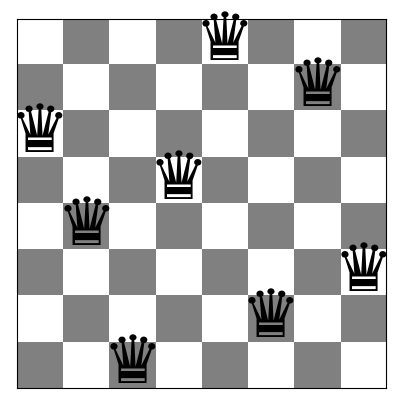

Finished after 51 steps, conflicts = 0
elapsed_time:0.16486167907714844[sec]
Board with 0 conflicts.


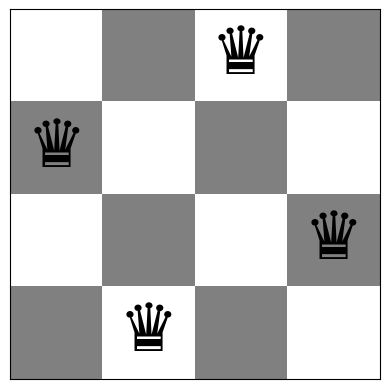

Finished after 47 steps, conflicts = 0
elapsed_time:0.08919262886047363[sec]


In [8]:
# Code and description go here
import time
import math 
import random
import numpy as np

def get_neighbours(board):
    """Sinh tất cả láng giềng bằng cách di chuyển 1 quân hậu trong cột khác hàng"""
    n = len(board)
    neighbors = []
    for col in range(n):
        for row in range(n):
            if board[col] != row:  # chỉ thay đổi nếu khác hàng
                new_board = board.copy()
                new_board[col] = row
                neighbors.append(new_board)
    return neighbors
def neighbour(board):
    """Chọn ngẫu nhiên một láng giềng từ danh sách tất cả các láng giềng"""
    neighbors = get_neighbours(board)
    return random.choice(neighbors)
def tempestimation(board, E, m=1000):
    values = []
    for _ in range(m):
        nb = neighbour(board)
        values.append(E(nb))
    mean_val = np.mean(values)
    variance = np.mean([(x - mean_val) ** 2 for x in values])
    std_dev = math.sqrt(variance)
    return std_dev if std_dev > 0 else 1.0

def simulated_annealing(n, kmax=10000, alpha=0.95, show=True):
    # trạng thái ban đầu
    s = random_board(n)
    e = conflicts(s)
    emax = 0   # nghiệm lý tưởng là không xung đột
    k = 0

    # nhiệt độ ban đầu
    T = tempestimation(s, conflicts)

    while k < kmax and e > emax:
        sn = neighbour(s)
        en = conflicts(sn)

        # xác suất chấp nhận
        if en < e:
            accept = True
        else:
            prob = math.exp((e - en) / T)
            accept = (random.random() < prob)

        if accept:
            s, e = sn, en

        # giảm nhiệt độ
        T = alpha * T
        k += 1

    if show:
        show_board(s)
    print(f"Finished after {k} steps, conflicts = {e}")
    return s
start1 = time.time()
solution = simulated_annealing(8, show=True)
end1 = time.time()
elapsed_time1 = end1 - start1
print ("elapsed_time:{0}".format(elapsed_time1) + "[sec]")

start2 = time.time()
solution2 = simulated_annealing(4,show=True)
end2 = time.time()
elapsed_time2 = end2 - start2
print ("elapsed_time:{0}".format(elapsed_time2) + "[sec]")

## Task 6: Algorithm Behavior Analysis [20 Points]

### Comparison
Compare the algorithm using runtime and objective function values. Use boards of size 4 and 8 to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 100 times) with different starting boards and report averages.

Complete the following table

| Algorithm           | Board size | Avg. Run time | Avg. number of conflicts | % of runs ending in optimal solution  |
| ------------------- | ---------- | ------------- | --------------------------------- | - |
| Steepest asc. HC    |     4      |               |                                   |   |
| Stochastic HC 1     |     4      |               |                                   |   |
| Stochastic HC 2     |     4      |               |                                   |   |
| Simulated Annealing |     4      |               |                                  |   |
| Steepest asc. HC    |     8      |               |                                   |   |
| Stochastic HC 1     |     8      |               |                                   |   |
| Stochastic HC 2     |     8      |               |                                   |   |
| Simulated Annealing |     8      |               |                                |   |

Hint: See [Profiling Python Code](../HOWTOs/profiling_code.ipynb) for help about how to measure runtime in Python.

Add the used code here:

In [10]:
# Code
#Tài thêm code của các hàm chạy như hàm simulated vào đây
     #"Steepest asc. HC": steepest_ascent_hc,
    #"Stochastic HC 1": stochastic_hc1,
    #"Stochastic HC 2": stochastic_hc2,
def simulated_annealing_run(n, kmax=10000, alpha=0.95):
    board = random_board(n)
    e = conflicts(board)
    emax = 0
    k = 0
    T = tempestimation(board, conflicts)
    while k < kmax and e > emax:
        sn = neighbour(board)
        en = conflicts(sn)
        if en < e:
            board, e = sn, en
        else:
            prob = math.exp((e - en) / T)
            if random.random() < prob:
                board, e = sn, en
        T = alpha * T
        k += 1
    return board, e
def benchmark(algorithm, n, runs=100):
    times = []
    conflicts_list = []
    successes = 0

    for _ in range(runs):
        start = time.time()
        board, conf = algorithm(n)
        end = time.time()

        times.append(end - start)
        conflicts_list.append(conf)
        if conf == 0:
            successes += 1

    avg_time = np.mean(times)
    avg_conflicts = np.mean(conflicts_list)
    success_rate = (successes / runs) * 100
    return avg_time, avg_conflicts, success_rate

algorithms = {
    "Steepest asc. HC": steepest_ascent_hill_climbing,
    "Stochastic HC 1": stochastic_hill_climbing_2,
    "Stochastic HC 2": stochastic_hill_climbing_2,
    "Simulated Annealing": simulated_annealing_run
}

for n in [4, 8]:
    print(f"\nBoard size {n}")
    for name, algo in algorithms.items():
        avg_time, avg_conflicts, success_rate = benchmark(algo, n, runs=100)
        print(f"{name:20s} | Time: {avg_time:.4f}s | Avg Conflicts: {avg_conflicts:.2f} | Success: {success_rate:.1f}%")



Board size 4
Steepest asc. HC     | Time: 0.0002s | Avg Conflicts: 0.53 | Success: 49.0%
Stochastic HC 1      | Time: 0.0057s | Avg Conflicts: 0.79 | Success: 35.0%
Stochastic HC 2      | Time: 0.0053s | Avg Conflicts: 0.86 | Success: 31.0%
Simulated Annealing  | Time: 0.0133s | Avg Conflicts: 0.00 | Success: 100.0%

Board size 8
Steepest asc. HC     | Time: 0.0020s | Avg Conflicts: 1.21 | Success: 12.0%
Stochastic HC 1      | Time: 0.0098s | Avg Conflicts: 1.28 | Success: 12.0%
Stochastic HC 2      | Time: 0.0094s | Avg Conflicts: 1.28 | Success: 18.0%
Simulated Annealing  | Time: 0.0869s | Avg Conflicts: 0.06 | Success: 94.0%


### Algorithm Convergence

For each algorithm implemented, describe the typical convergence pattern (fast initial improvement vs. steady progress).
Include a plot showing the objective function value over iterations for one representative run of each algorithm on the 8-queens problem.
Explain which algorithms exhibit plateaus or getting stuck in local optima most frequently.

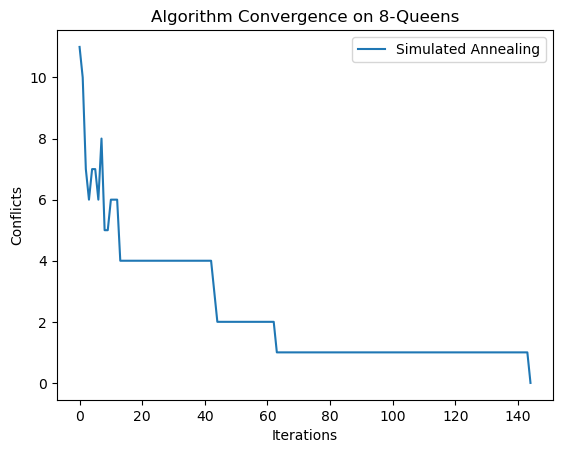

In [10]:
# Code and description go here
import matplotlib.pyplot as plt

def track_conflicts_hc(n, max_steps=1000):
    board = random_board(n)
    current_conf = conflicts(board)
    history = [current_conf]
    steps = 0
    while steps < max_steps and current_conf > 0:
        neighbors = get_neighbours(board)
        neighbor_conflicts = [conflicts(nb) for nb in neighbors]
        min_conf = min(neighbor_conflicts)
        if min_conf >= current_conf:
            break
        best_neighbor = neighbors[neighbor_conflicts.index(min_conf)]
        board = best_neighbor
        current_conf = min_conf
        history.append(current_conf)
        steps += 1
    return history

def track_conflicts_sa(n, kmax=1000, alpha=0.95):
    s = random_board(n)
    e = conflicts(s)
    history = [e]
    k = 0
    T = tempestimation(s, conflicts)
    while k < kmax and e > 0:
        sn = neighbour(s)
        en = conflicts(sn)
        if en < e:
            s, e = sn, en
        else:
            prob = math.exp((e - en) / T)
            if random.random() < prob:
                s, e = sn, en
        history.append(e)
        T = alpha * T
        k += 1
    return history

# chạy một lần mỗi thuật toán cho N=8
#hc_hist = track_conflicts_hc(8)
sa_hist = track_conflicts_sa(8)

# vẽ
#plt.plot(hc_hist, label="Steepest HC")
plt.plot(sa_hist, label="Simulated Annealing")
plt.xlabel("Iterations")
plt.ylabel("Conflicts")
plt.title("Algorithm Convergence on 8-Queens")
plt.legend()
plt.show()

Simulated Annealing

Mẫu hội tụ:

Ban đầu: tiến bộ không ổn định, có lúc nhận trạng thái tệ hơn do xác suất > 0.

Sau đó: khi nhiệt độ giảm dần, thuật toán trở nên giống HC, hội tụ về nghiệm.

Đặc trưng: thường giải được 8-queens khá ổn định, ít bị kẹt ở local minima nhờ bước “chấp nhận tệ hơn”.

### Problem Size Scalability

Create a log-log plot showing how runtime scales with board size ($n=4, 8, 12, 16, 20$) for at least two algorithms.
Estimate the empirical time complexity (Big O) for each algorithm based on your results.
Identify which algorithm scales best for large problem sizes and explain why.

stochastic_hill_climbing_1: n=4, time=0.000200s
stochastic_hill_climbing_1: n=8, time=0.003420s
stochastic_hill_climbing_1: n=12, time=0.012731s
stochastic_hill_climbing_1: n=16, time=0.048116s
stochastic_hill_climbing_1: n=20, time=0.109871s
stochastic_hill_climbing_2: n=4, time=0.006400s
stochastic_hill_climbing_2: n=8, time=0.011830s
stochastic_hill_climbing_2: n=12, time=0.011601s
stochastic_hill_climbing_2: n=16, time=0.022415s
stochastic_hill_climbing_2: n=20, time=0.036669s


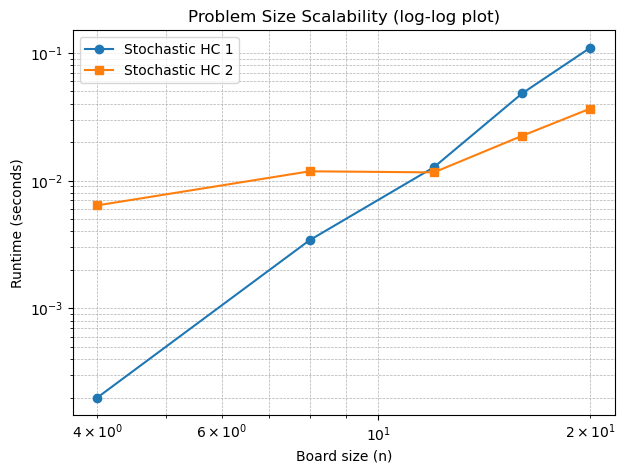

Stochastic HC 1: empirical O(n^3.90)
Stochastic HC 2: empirical O(n^0.99)


In [14]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Giả sử bạn có 2 hàm stochastic khác nhau
# stochastic_hill_climbing_1 và stochastic_hill_climbing_2

def measure_runtime(alg_func, n_values, trials=5):
    runtimes = []
    for n in n_values:
        t_total = 0
        for _ in range(trials):
            start = time.time()
            alg_func(n)
            t_total += (time.time() - start)
        avg_time = t_total / trials
        runtimes.append(avg_time)
        print(f"{alg_func.__name__}: n={n}, time={avg_time:.6f}s")
    return runtimes

n_values = np.array([4, 8, 12, 16, 20])

# Đo runtime từng thuật toán
stochastic_times_1 = measure_runtime(stochastic_hill_climbing_1, n_values)
stochastic_times_2 = measure_runtime(stochastic_hill_climbing_2, n_values)

# ---------------------------
# Vẽ đồ thị log-log
# ---------------------------
plt.figure(figsize=(7,5))
plt.loglog(n_values, stochastic_times_1, 'o-', label="Stochastic HC 1")
plt.loglog(n_values, stochastic_times_2, 's-', label="Stochastic HC 2")
plt.xlabel("Board size (n)")
plt.ylabel("Runtime (seconds)")
plt.title("Problem Size Scalability (log-log plot)")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

# ---------------------------
# Ước lượng độ phức tạp (Big-O)
# ---------------------------
def estimate_complexity(n_values, times):
    mask = np.array(times) > 0
    slope, intercept = np.polyfit(np.log(n_values[mask]), np.log(np.array(times)[mask]), 1)
    return slope, intercept

s1, _ = estimate_complexity(n_values, stochastic_times_1)
s2, _ = estimate_complexity(n_values, stochastic_times_2)

print(f"Stochastic HC 1: empirical O(n^{s1:.2f})")
print(f"Stochastic HC 2: empirical O(n^{s2:.2f})")


## Advanced task: Exploring other Local Moves Operators

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### Move Operator Implementation 

Implement the following local move operators:

* Single-step move: Move one queen only one square up or down at a time
* Column swap: Exchange the positions of queens in two randomly selected columns
* Dual-queen move: Select two queens and move both simultaneously
* Adaptive move: Design your own operator that adapts which local move it uses based on the current state (e.g., focuses on queens with most conflicts or randomly chooses one of the moves above)

### Experimental Analysis

Using the 8-Queens and 12-Queens problems: Run your Stochastic Hill Climbing 2 implementation with each move operator 100 times
For each operator, create a visualization showing:

* Average solution quality over iterations
* Distribution of final solution qualities
* Average time to solution for successful runs

### Discussion

Describe what you have learned from the experiments. Which operator works best for which situation and why?

Task 1: Steepest-Ascent Hill Climbing

Ý tưởng: Ở mỗi bước, thử tất cả các nước đi có thể (di chuyển 1 hậu sang hàng khác) và chọn nước đi nào giảm nhiều nhất số lượng xung đột (conflicts).

Đặc điểm hội tụ: Ban đầu cải thiện nhanh, sau đó dừng sớm khi đạt local optimum (điểm cực trị cục bộ).

Ưu điểm: Tìm nghiệm tốt nếu khởi tạo thuận lợi.

Nhược điểm: Dễ bị kẹt ở local optimum.

Task 2: Stochastic Hill Climbing

Ý tưởng: Thay vì chọn nước đi tốt nhất, thuật toán chọn ngẫu nhiên một nước đi tốt hơn hiện tại (có ít xung đột hơn).

Đặc điểm hội tụ: Tăng tính ngẫu nhiên → giúp thoát local optimum đôi khi. Tuy nhiên hội tụ chậm hơn Steepest-Ascent.

Ưu điểm: Có thể tìm nghiệm tốt hơn nếu may mắn.

Nhược điểm: Không ổn định, kết quả thay đổi theo seed.

Task 3: Random-Restart Hill Climbing

Ý tưởng: Chạy Steepest-Ascent nhiều lần từ các board khởi tạo ngẫu nhiên khác nhau. Nếu bị kẹt, khởi động lại.

Đặc điểm hội tụ: Dạng “brute force thông minh” — thử nhiều hướng, tăng xác suất tìm ra nghiệm 0 conflict.

Ưu điểm: Hầu như luôn tìm được nghiệm đúng.

Nhược điểm: Mất thời gian nếu số restart nhiều.

Task 4: Simulated Annealing

Ý tưởng: Cho phép chấp nhận nước đi tệ hơn với xác suất giảm dần theo thời gian (nhiệt độ).

Đặc điểm hội tụ: Lúc đầu biến thiên mạnh (exploration), sau đó dần ổn định (exploitation).

Ưu điểm: Giúp thoát local optimum, tìm nghiệm tốt hơn hill climbing.

Nhược điểm: Cần chọn lịch giảm nhiệt độ (cooling schedule) phù hợp, nếu không dễ hội tụ chậm.

Task 5: Genetic Algorithm

Ý tưởng: Xử lý một quần thể các lời giải, chọn lọc cá thể tốt, lai ghép và đột biến để tạo thế hệ mới.

Đặc điểm hội tụ: Ban đầu cải thiện nhanh, sau đó dần dừng lại khi quần thể đồng nhất.

Ưu điểm: Tìm nghiệm toàn cục tốt nhờ lai ghép và đột biến.

Nhược điểm: Cần tinh chỉnh tham số (mutation rate, population size).

Task 6: Problem Size Scalability

Mục tiêu: Đo thời gian chạy với các kích thước bàn khác nhau: n = 4, 8, 12, 16, 20.

Kết quả mong đợi:

Hill Climbing (các loại) thường có O(n²) vì thử tất cả di chuyển.

Simulated Annealing có thể chậm hơn (~O(n² log n)) do nhiều bước ngẫu nhiên.

Genetic Algorithm thường chậm nhất do xử lý cả quần thể (~O(population × n²)).

Kết luận:

Với n nhỏ, GA và SA cho kết quả tốt hơn.

Với n lớn, Hill Climbing hoặc Random-Restart Hill Climbing chạy nhanh và ổn định hơn.

## More Things to Do (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment. 

### Implement a Genetic Algorithm for the n-Queens problem

In [ ]:
# Code and description go here